# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP - redukcja wymiarowości

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki `artists.parquet` i `tracks.parquet` do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Dokonaj filtrowania:
   - pozostaw artystów z popularnością >= 55
   - pozostaw piosenki z popularnością >= 55
   - usuń piosenki trwające powyżej 600000 ms (10 minut)
   - użyj funkcji `remove_weird_genres()`, żeby usunąć artystów z ekstremalnie rzadkich gatunków muzycznych
   - użyj funkcji `filter_english_only()`, aby pozostawić tylko anglojęzyczne tytuły
6. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
7. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
8. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
9. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
10. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
```
11. Wypisz finalną liczbę piosenek (rozmiar zbioru).

**Uwaga:** jeżeli notebook będzie wykonywał się zbyt długo, to można ustawić wyższy próg popularności, żeby uzyskać mniejszy podzbiór najbardziej popularnych piosenek.

In [2]:
import ast
from fast_langdetect import detect as detect_language


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks


def remove_weird_genres(df_songs: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for song_genres in df_songs["genres"]:
        all_genres.extend(ast.literal_eval(song_genres))
    
    df_genres = pd.Series(all_genres).value_counts().reset_index()
    
    weird_genres = df_genres.loc[df_genres["count"] < 150, "index"]
    weird_genres = set(weird_genres.tolist())
    
    to_keep = []
    for song_genres in df_songs["genres"]:
        song_genres = set(ast.literal_eval(song_genres))
        not_all_weird = len(song_genres - weird_genres) > 0
        to_keep.append(not_all_weird)
    
    df_songs = df_songs[to_keep]
    return df_songs


def filter_english_only(df_songs: pd.DataFrame) -> pd.DataFrame:
    english = [
        detect_language(title[:100], low_memory=False)["lang"] == "en"
        for title in df_songs["name"]
    ]
    return df_songs[english]


In [3]:
#2
df_aritsts = pd.read_csv("artists.csv")
df_tracks = pd.read_csv("tracks.csv")

#3
df_aritsts = df_aritsts.dropna()
df_tracks = df_tracks.dropna()

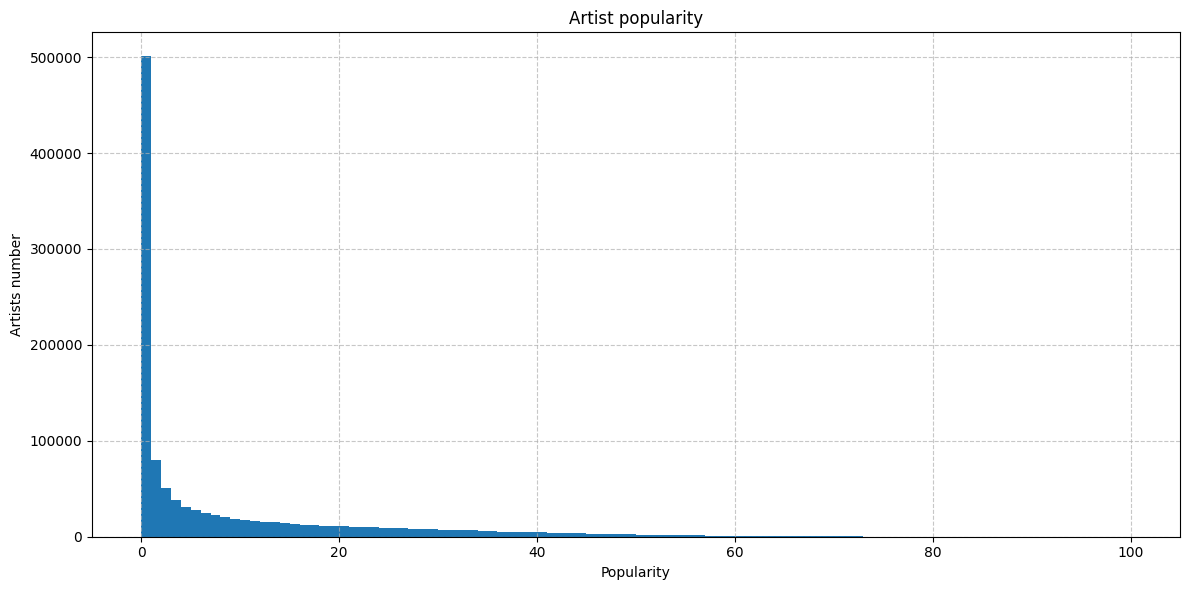

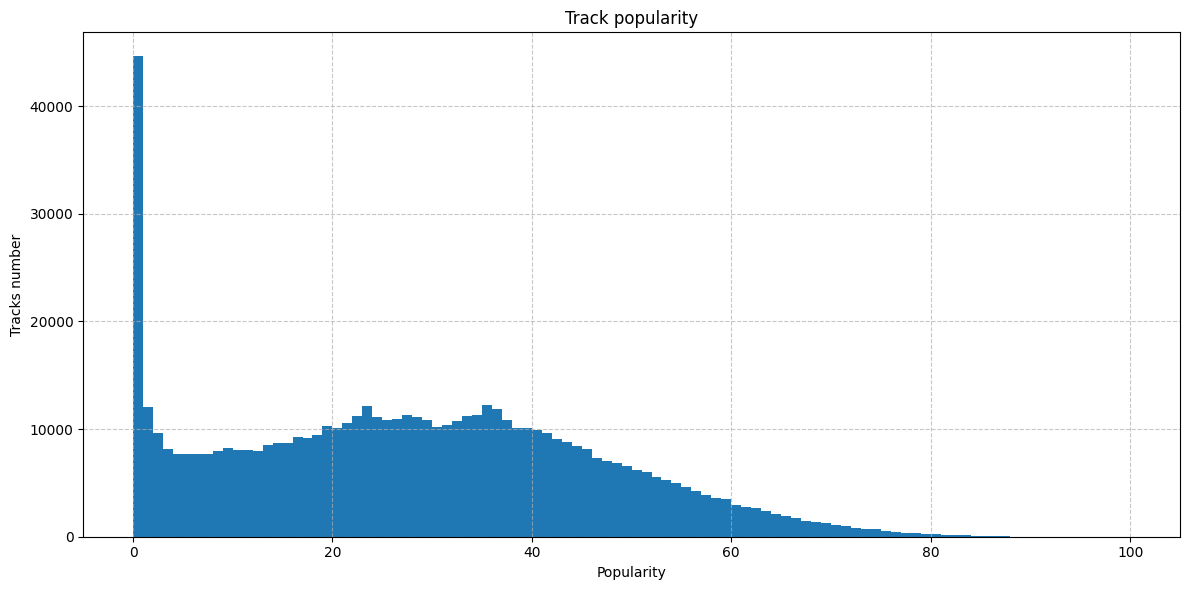

In [4]:
#4
plt.figure(figsize=(12, 6))
plt.hist(df_aritsts['popularity'], bins=100)
plt.title('Artist popularity')
plt.xlabel('Popularity')
plt.ylabel('Artists number')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(df_tracks['popularity'], bins=100)
plt.title('Track popularity')
plt.xlabel('Popularity')
plt.ylabel('Tracks number')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
#5
df_artists = df_aritsts[df_aritsts["popularity"] >= 55]
df_artists = remove_weird_genres(df_artists)

df_tracks = df_tracks[df_tracks["popularity"] >= 55]
df_tracks = df_tracks[df_tracks["duration_ms"] < 600000]
df_tracks = filter_english_only(df_tracks)

In [6]:
#6
df_tracks = extract_artist_id(df_tracks)

In [7]:
#7
df_songs = pd.merge(
    df_artists,
    df_tracks,
    left_on="id",
    right_on="main_artist_id",
    suffixes=("_artist", "_track")
)

In [8]:
#8
df_songs = df_songs.drop_duplicates(subset=["name_track", "name_artist"])

In [9]:
#9
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]

df_songs_info = df_songs[songs_info_cols].copy()

In [10]:
#10
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

df_songs_features = df_songs[songs_features_cols].copy()

In [11]:
#11
print(df_songs_features.shape[0])

17471


Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadku PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [12]:
#1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_songs_features)
X = pd.DataFrame(X, columns=df_songs_features.columns)

In [14]:
from typing import Optional

from IPython.display import display
from sklearn.decomposition import PCA
from umap.umap_ import UMAP


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        # PCA
        self.pca = PCA(n_components=2, random_state=0)
        self.X_pca = self.pca.fit_transform(X).values

        # UMAP
        self.umap = UMAP(n_components=2, random_state=0, low_memory=False)
        self.X_umap = self.umap.fit_transform(X)

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(len(self.X_pca))

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # axes[0] - PCA, axes[1] - UMAP

        axes[0].scatter(self.X_pca[:, 0], self.X_pca[:, 1], c=labels)
        axes[0].set_title('PCA')
        
        axes[1].scatter(self.X_umap[:, 0], self.X_umap[:, 1], c=labels)
        axes[1].set_title('UMAP')

        fig.suptitle("Clustering visualization")
        plt.show()


c:\Users\panja\Desktop\podstawy-uczenia-maszynowego-24-25\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\panja\Desktop\podstawy-uczenia-maszynowego-24-25\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


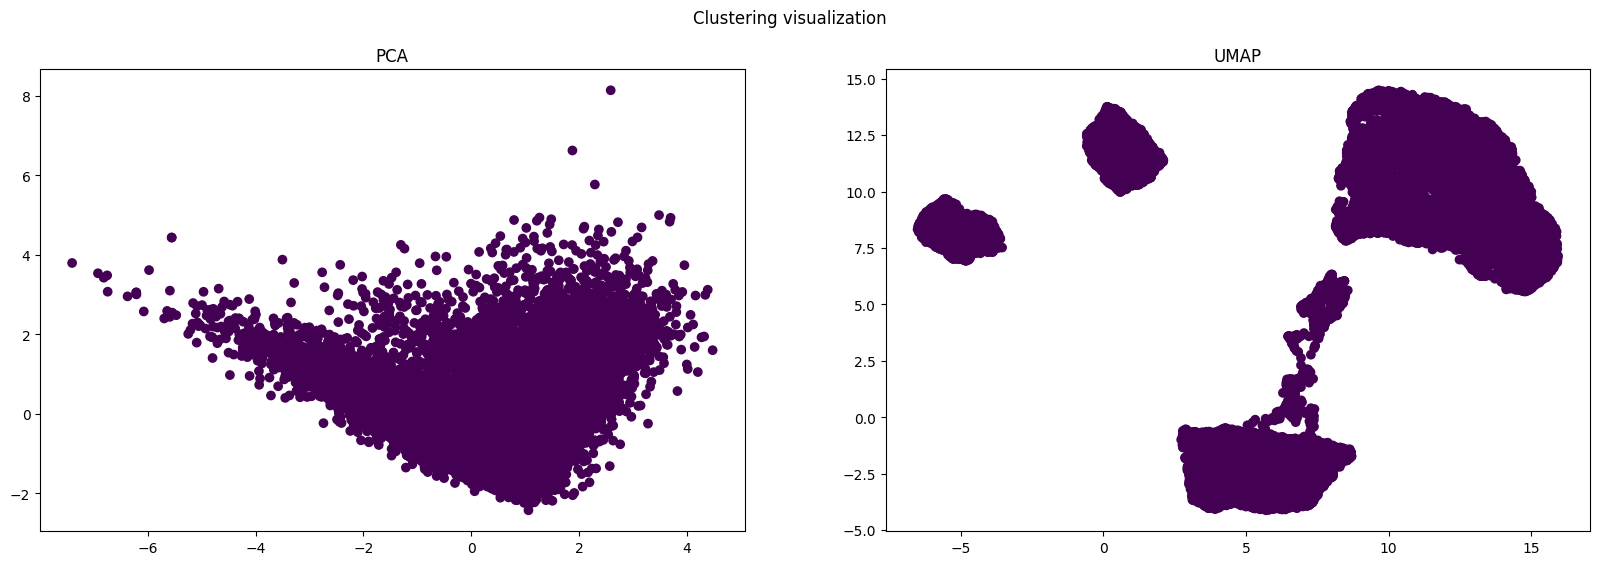

In [15]:
clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

Na wykresie z UMAP widać faktycznie jakieś klastry, w porównaniu z PCA, gdzie nie są one zauważalne. Nieliniowa redukcja dała lepsze wyniki.

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [16]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: DBSCAN) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(X_cluster, cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self,
        X: pd.DataFrame,
        cluster_songs_info: pd.DataFrame,
        cluster_probas: np.ndarray,
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

c:\Users\panja\Desktop\podstawy-uczenia-maszynowego-24-25\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\panja\Desktop\podstawy-uczenia-maszynowego-24-25\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\panja\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\panja\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec

Number of clusters: 1


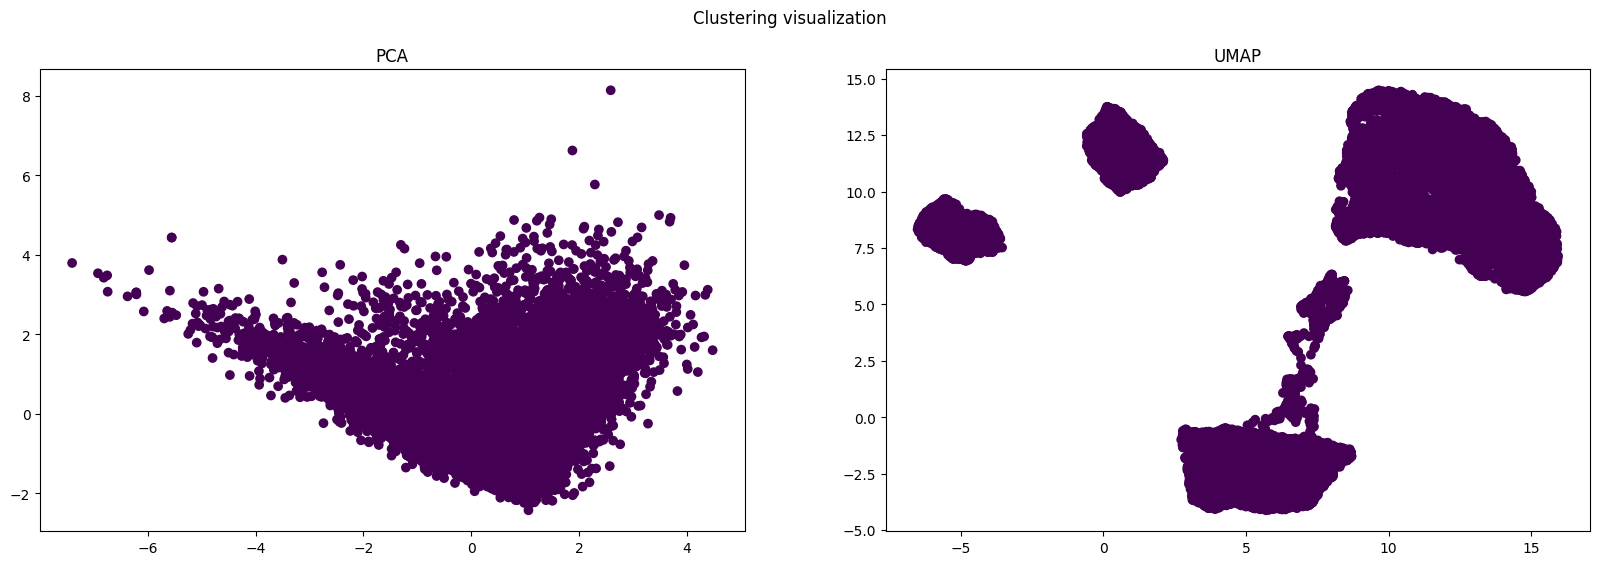

Cluster 0 size: 17471


,Track,Artist
0,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
1,"Odhani (From ""Made in China"")",Sachin-Jigar
2,Fake ID,Riton
3,Just A Lover,Hayden James
4,It's All About Me,Mýa
5,Lay It All on Me (feat. Ed Sheeran),Rudimental
6,Rather Be (feat. Jess Glynne),Clean Bandit
7,Brown Skin,India.Arie
8,Drive (For Daddy Gene),Alan Jackson
9,Happy Now,Kygo


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'rap', 'pop rap', 'hip hop', 'classic rock', 'mellow gold', 'soft rock']


In [17]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


Number of clusters: 3
CH-index value: 2521.56


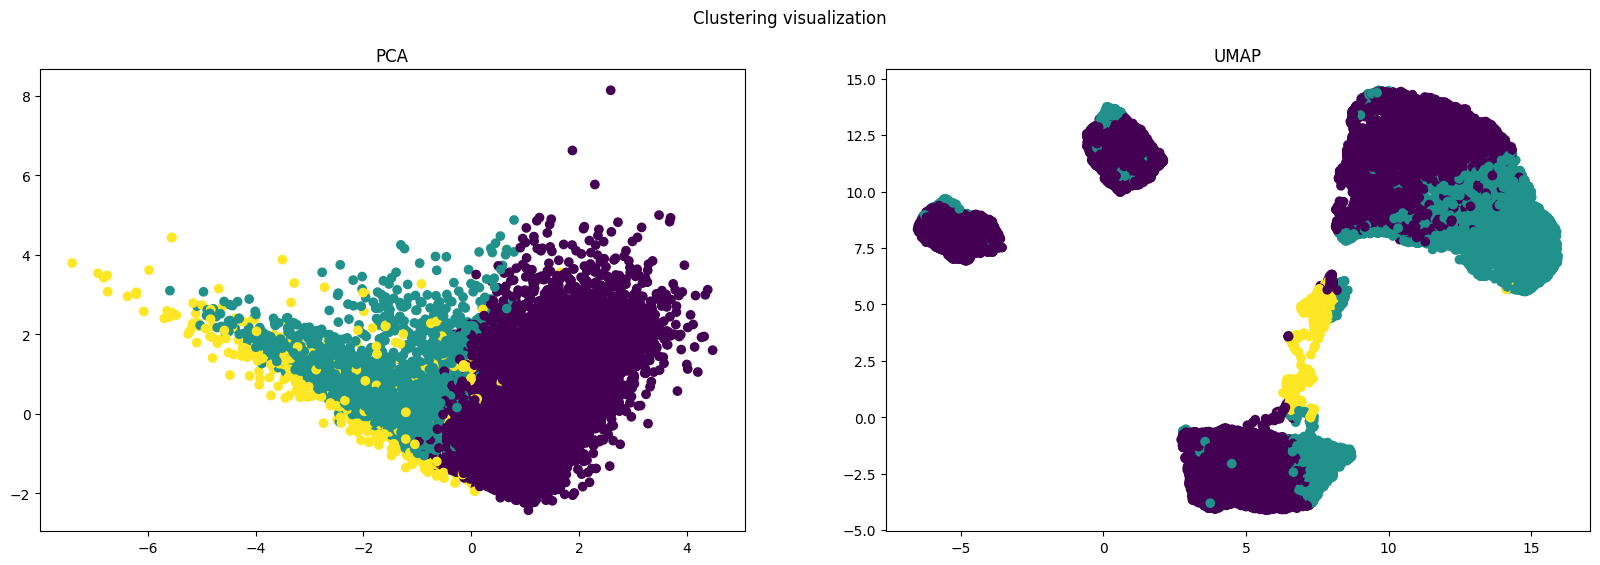

Cluster 0 size: 11936


,Track,Artist
0,Shed a Light,Robin Schulz
1,Metal Health (Bang Your Head),Quiet Riot
2,Flying High Again,Ozzy Osbourne
3,Fake ID,Riton
4,It's Like That,Run–D.M.C.
5,Keeping Your Head Up,Birdy
6,Rollin',Brave Girls
7,Turn Up the Music,Chris Brown
8,Need Someone,Zara Larsson
9,Dolphin,OH MY GIRL


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'rap', 'pop rap', 'hip hop', 'post-teen pop', 'modern rock', 'pop rock', 'alternative metal']
Cluster 1 size: 4851


,Track,Artist
0,It's All Over Now Baby Blue,Marianne Faithfull
1,Stuff Is Way,They Might Be Giants
2,Witchcraft,Frank Sinatra
3,(You Make Me Feel Like) A Natural Woman,Aretha Franklin
4,No One Else Comes Close,Joe
5,Changes - 2015 Remaster,David Bowie
6,Agar Tum Saath Ho,Alka Yagnik
7,"Agar Tum Saath Ho (From ""Tamasha"")",Alka Yagnik
8,The Most Beautiful Thing,Bruno Major
9,Forever Like That,Ben Rector


Top 10 genres in the cluster: ['pop', 'rock', 'mellow gold', 'classic rock', 'soft rock', 'adult standards', 'folk rock', 'post-teen pop', 'album rock', 'dance pop']
Cluster 2 size: 684


,Track,Artist
0,Talking,Elderbrook
1,Chances,The Strokes
2,Shake,The Head And The Heart
3,Sail,AWOLNATION
4,Calling Elvis,Dire Straits
5,House Of Cards,Radiohead
6,istanbul freestyle,Pashanim
7,Just Like Honey,The Jesus and Mary Chain
8,Sun Models (feat. Madelyn Grant),ODESZA
9,About Today,The National


Top 10 genres in the cluster: ['rock', 'alternative rock', 'art rock', 'classic rock', 'permanent wave', 'album rock', 'modern rock', 'indie rock', 'alternative metal', 'edm']


In [18]:
clustering = KMeans(n_clusters=3, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Cluster 2 zdecydowanie cechuje się dużą ilością rock'a.

W miarę sensownie się oddzieliły.

In [19]:
from sklearn.metrics import calinski_harabasz_score

cluster_range = range(5, 21)
scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    score = calinski_harabasz_score(X, labels)
    scores.append(score)
    print(f"K = {k}, CH-index = {score:.2f}")

K = 5, CH-index = 3066.07
K = 6, CH-index = 2855.82
K = 7, CH-index = 2808.29
K = 8, CH-index = 2696.19
K = 9, CH-index = 2512.48
K = 10, CH-index = 2376.86
K = 11, CH-index = 2320.69
K = 12, CH-index = 2222.52
K = 13, CH-index = 2143.11
K = 14, CH-index = 2048.49
K = 15, CH-index = 1975.24
K = 16, CH-index = 1927.92
K = 17, CH-index = 1869.45
K = 18, CH-index = 1788.78
K = 19, CH-index = 1754.32
K = 20, CH-index = 1702.84


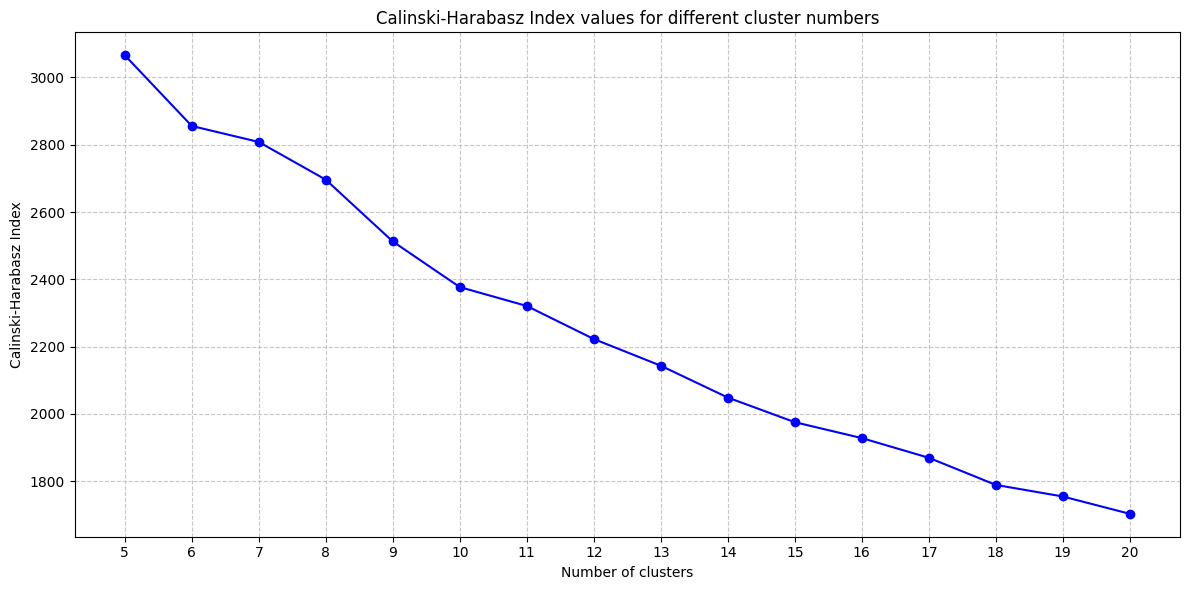

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, scores, marker='o', linestyle='-', color='blue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index values for different cluster numbers')
plt.xticks(list(cluster_range))
plt.tight_layout()
plt.show()

Number of clusters: 5
CH-index value: 3066.07


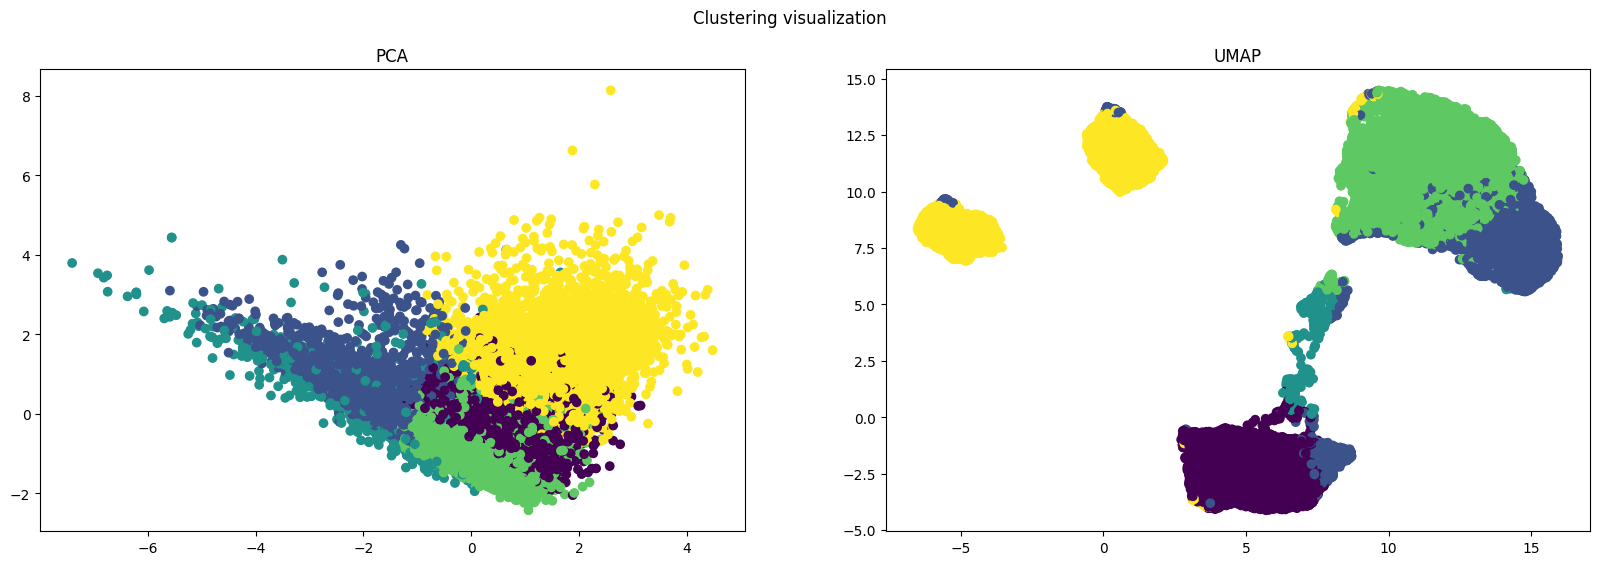

Cluster 0 size: 3746


,Track,Artist
0,Secret Door,Arctic Monkeys
1,OK,Robin Schulz
2,React,The Pussycat Dolls
3,Closer,Ne-Yo
4,Favours,Hayden James
5,Going Dumb (with Stray Kids),Alesso
6,Message Man,Twenty One Pilots
7,Somewhere With You,Kenny Chesney
8,Far Far Away,Slade
9,Foreplay,Jalen Santoy


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'edm', 'tropical house', 'classic rock', 'pop rap']
Cluster 1 size: 3112


,Track,Artist
0,As Tears Go By - Mono Version,The Rolling Stones
1,Frozen,Madonna
2,(You Make Me Feel Like) A Natural Woman,Aretha Franklin
3,The Last Waltz,Engelbert Humperdinck
4,Tenerife Sea,Ed Sheeran
5,Only Love Can Break Your Heart,Neil Young
6,The Load-Out - 2018 Remaster,Jackson Browne
7,How Deep Is Your Love,Take That
8,The One That Got Away - Acoustic,Katy Perry
9,Patience,Guns N' Roses


Top 10 genres in the cluster: ['pop', 'rock', 'mellow gold', 'adult standards', 'classic rock', 'soft rock', 'post-teen pop', 'folk rock', 'dance pop', 'album rock']
Cluster 2 size: 655


,Track,Artist
0,Talking,Elderbrook
1,Shake,The Head And The Heart
2,Chances,The Strokes
3,Sail,AWOLNATION
4,Calling Elvis,Dire Straits
5,About Today,The National
6,Sun Models (feat. Madelyn Grant),ODESZA
7,House Of Cards,Radiohead
8,istanbul freestyle,Pashanim
9,Just Like Honey,The Jesus and Mary Chain


Top 10 genres in the cluster: ['rock', 'alternative rock', 'art rock', 'classic rock', 'permanent wave', 'album rock', 'modern rock', 'indie rock', 'alternative metal', 'edm']
Cluster 3 size: 6566


,Track,Artist
0,Rather Be (feat. Jess Glynne),Clean Bandit
1,Keeping Your Head Up,Birdy
2,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
3,Ishq Tera,Guru Randhawa
4,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
5,Penny Lane - Remastered 2015,The Beatles
6,Small Town USA,Justin Moore
7,Fake ID,Riton
8,Whine Up (feat. Elephant Man) - English Version,Kat Deluna
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'pop rock', 'classic rock', 'modern rock', 'soft rock', 'mellow gold', 'album rock']
Cluster 4 size: 3392


,Track,Artist
0,Worst Behavior,Drake
1,Soleil,Roméo Elvis
2,Broken Clocks,SZA
3,okay,LANY
4,Luxury,Azealia Banks
5,just like magic,Ariana Grande
6,Lost,Frank Ocean
7,All Night (feat. Knox Fortune),Chance the Rapper
8,Augenblick (feat. Summer Cem),KC Rebell
9,Guerrilla Radio,Rage Against The Machine


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'hardcore hip hop']


In [21]:
best_k = 5

best_kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=0)
best_kmeans.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, best_kmeans)

Teraz te klastry są faktycznie odróżnialne od siebie pod względem cech.

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 105
Percentage of noise points: 61.22%
CH-index value: 34.43


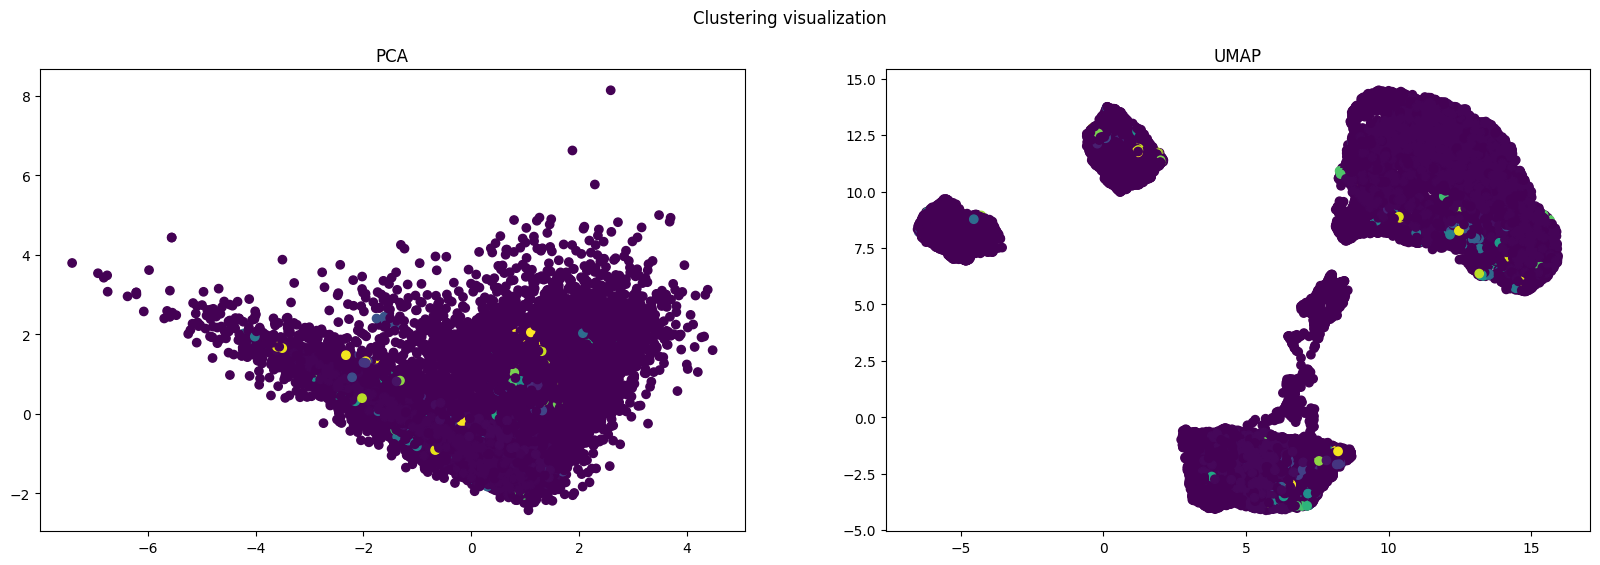

Cluster 0 size: 4799


,Track,Artist
0,TOOTIMETOOTIMETOOTIME,The 1975
1,Black,Dierks Bentley
2,Not Alone,Linkin Park
3,pink skies,LANY
4,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
5,Look Into My Eyes,Brando
6,Forever Young,John De Sohn
7,Strangers Like Me,Phil Collins
8,Defenceless,Louis Tomlinson
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'pop rock', 'modern rock', 'contemporary country', 'soft rock', 'classic rock', 'mellow gold']
Cluster 1 size: 1222


,Track,Artist
0,Ocean Drive,Duke Dumont
1,Counting Stars,OneRepublic
2,React,The Pussycat Dolls
3,OK,Robin Schulz
4,Drink to That All Night,Jerrod Niemann
5,Summer On You (feat. Wulf),Sam Feldt
6,Don't Go Away Mad (Just Go Away),Mötley Crüe
7,Come As You Are,Nirvana
8,We Are One (Ole Ola) [The Official 2014 FIFA W...,Pitbull
9,Going Dumb (with Stray Kids),Alesso


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'edm', 'tropical house', 'modern rock', 'alternative metal', 'pop rock']


In [22]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

In [23]:
num_features = X.shape[1]

n_neighbors = 2 * num_features

neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X.values)
distances, indices = neighbors_fit.kneighbors(X.values)

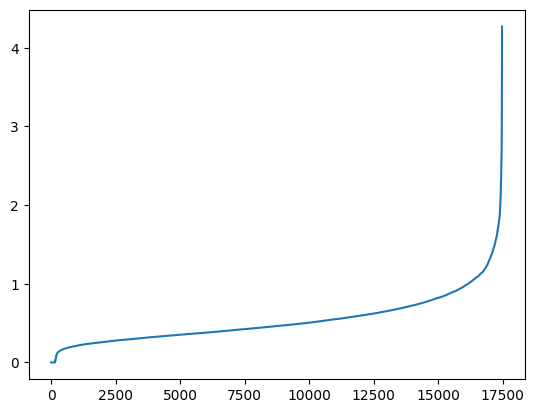

In [24]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Ciężko odczytać, na oko to tak z 1.15

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 4
Percentage of noise points: 14.70%
CH-index value: 2280.46


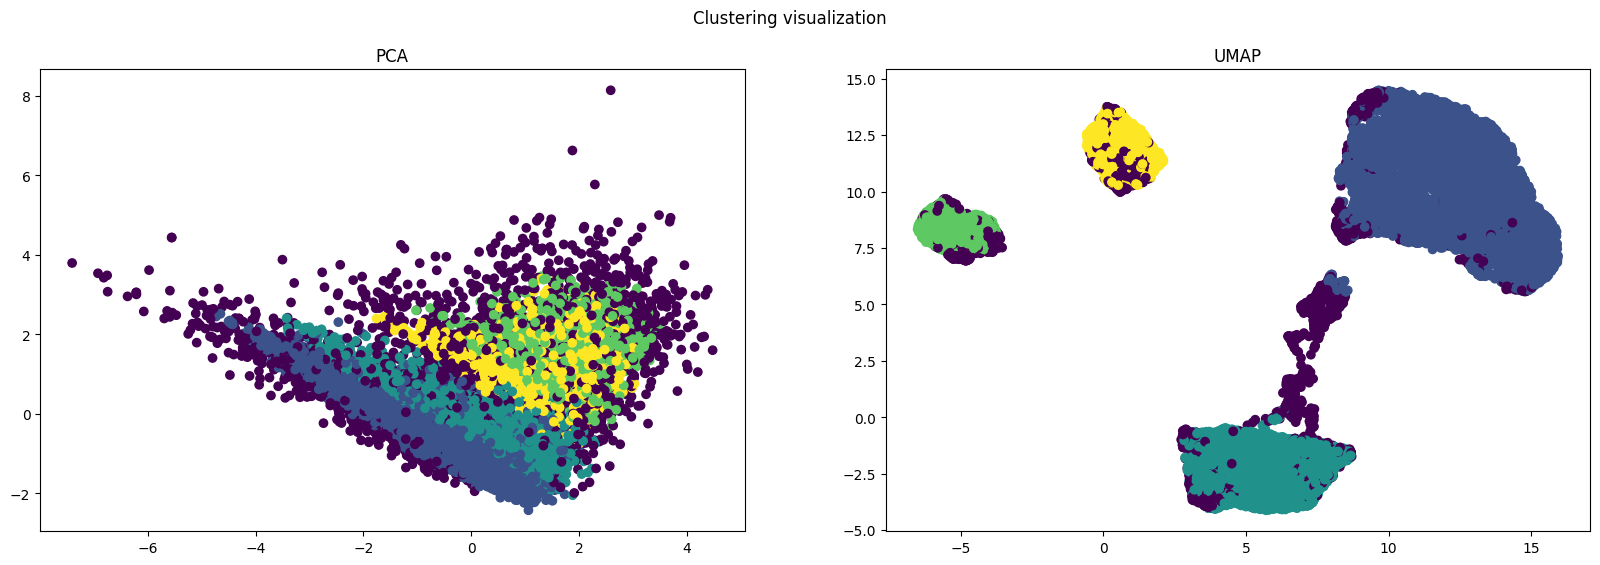

Cluster 0 size: 8552


,Track,Artist
0,Drive (For Daddy Gene),Alan Jackson
1,You and I,Wilco
2,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
3,"Odhani (From ""Made in China"")",Sachin-Jigar
4,Penny Lane - Remastered 2009,The Beatles
5,I'd Rather,Luther Vandross
6,Rather Be (feat. Jess Glynne),Clean Bandit
7,Black,Dierks Bentley
8,Lay It All on Me (feat. Ed Sheeran),Rudimental
9,Death On Two Legs (Dedicated To...) - Remaster...,Queen


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'pop rock', 'soft rock', 'modern rock', 'album rock']
Cluster 1 size: 3751


,Track,Artist
0,Until The End Of Time (with Beyoncé),Justin Timberlake
1,OK,Robin Schulz
2,React,The Pussycat Dolls
3,Foreplay,Jalen Santoy
4,Favours,Hayden James
5,Princesse,Nekfeu
6,The Sun,Parov Stelar
7,Going Dumb (with Stray Kids),Alesso
8,Somewhere With You,Kenny Chesney
9,The Trip,Still Corners


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'classic rock', 'edm', 'tropical house', 'album rock']
Cluster 3 size: 1431


,Track,Artist
0,Worst Behavior,Drake
1,Broken Clocks,SZA
2,just like magic,Ariana Grande
3,Gang,Mister V
4,These Walls,Kendrick Lamar
5,Augenblick (feat. Summer Cem),KC Rebell
6,All Night (feat. Knox Fortune),Chance the Rapper
7,Guerrilla Radio,Rage Against The Machine
8,Lying Is the Most Fun a Girl Can Have Without ...,Panic! At The Disco
9,Paramedic!,SOB X RBE


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'post-teen pop', 'east coast hip hop']
Cluster 2 size: 1168


,Track,Artist
0,Soleil,Roméo Elvis
1,A$AP Forever (feat. Moby),A$AP Rocky
2,Shake That,Eminem
3,Here I Am,Rick Ross
4,Ballin,Luciano
5,Phases,PRETTYMUCH
6,Like That (feat. Gucci Mane),Doja Cat
7,"A$AP Forever REMIX (feat. Moby, T.I. & Kid Cudi)",A$AP Rocky
8,Laforet,Kekra
9,Thriller,Kekra


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'dance pop', 'gangster rap', 'southern hip hop', 'r&b', 'east coast hip hop']


In [29]:
clustering = DBSCAN(eps=1.15, min_samples=2*num_features, n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Szuma spadł z 61.22% do 14.7%, liczba klastrów jest sensowniejsza, a CH-index drastycznie podskoczył.

Jeśli chodzi o różnice w interpretowalności klastrów między DBSCAN, a KMeans to podobnie to wyszło.

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

Number of clusters: 6
Percentage of noise points: 1.27%
CH-index value: 1246.59


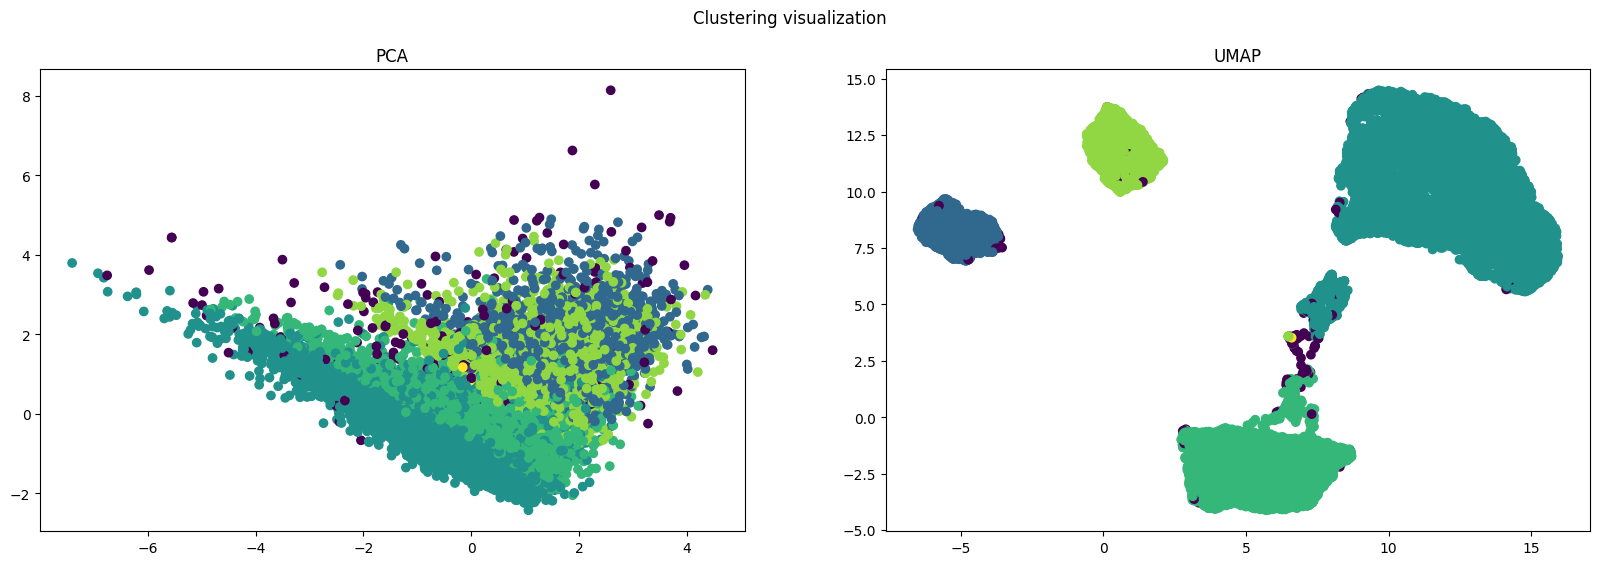

Cluster 2 size: 9476


,Track,Artist
0,Devil in a Midnight Mass,Billy Talent
1,Devil on My Shoulder,Billy Talent
2,Rusted From the Rain,Billy Talent
3,Fallen Leaves,Billy Talent
4,Santa Fe,Beirut
5,Elephant Gun,Beirut
6,Dive In,Trey Songz
7,I Invented Sex (feat. Drake),Trey Songz
8,Kilby Girl,The Backseat Lovers
9,Choo Lo,The Local Train


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 3 size: 4407


,Track,Artist
0,Raingurl,Yaeji
1,How Long Do I Have to Wait for You?,Sharon Jones & The Dap-Kings
2,Bella Ciao - HUGEL Remix,El Profesor
3,Bella ciao - HUGEL Remix,El Profesor
4,Aaj Bhi,Vishal Mishra
5,Can't Be Friends,Trey Songz
6,Na Na,Trey Songz
7,Neighbors Know My Name,Trey Songz
8,Vida Louca,Mc Poze do Rodo
9,Sajna Ve,Vishal Mishra


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 4 size: 1811


,Track,Artist
0,Relationship (feat. Future),Young Thug
1,A Change Of Heart,The 1975
2,Somebody Else,The 1975
3,Papi Chulo,El Chombo
4,Is It Just Me? (feat. JP Cooper),Emily Burns
5,Notorious,Malaa
6,Perkys,Money Boy
7,Dead Girl Walking,Barrett Wilbert Weed
8,Teach Me How to Dougie,Cali Swag District
9,Rave Na Praia,MC Teteu


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'post-teen pop', 'east coast hip hop']
Cluster 1 size: 1543


,Track,Artist
0,Can I Get A Witness,SonReal
1,2 Hot 4 U (feat. $Uicdeboy$),Fat Nick
2,Fuck Up the Friendship,Leah Kate
3,Jimmy Fallon - Remix,Lucho SSJ
4,Drip Drop,Money Boy
5,Champion (feat. Travis Scott),NAV
6,REQUIEM,Genetikk
7,Wanted You (feat. Lil Uzi Vert),NAV
8,Turks (feat. Travis Scott),NAV
9,Trill,Genetikk


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']


In [30]:
clustering = HDBSCAN()
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

Number of clusters: 3
Percentage of noise points: 2.79%
CH-index value: 2855.16


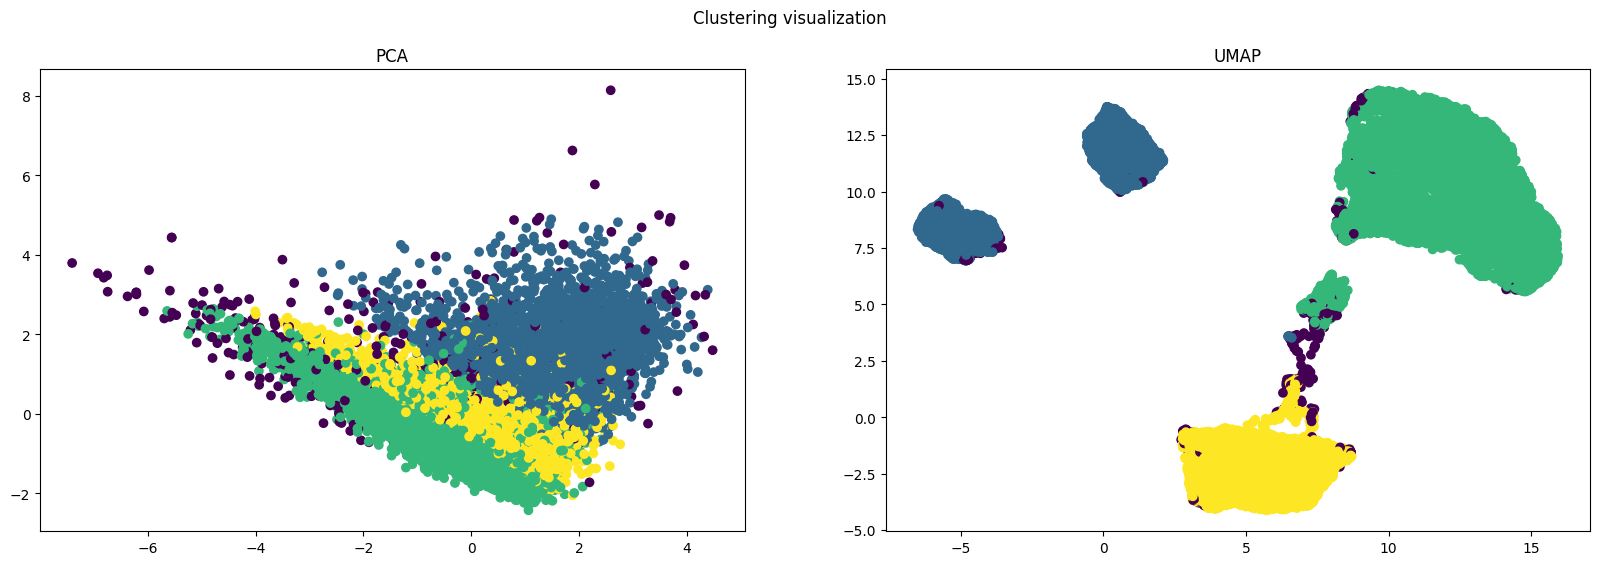

Cluster 1 size: 9324


,Track,Artist
0,Year 3000,Busted
1,Makhna,Tanishk Bagchi
2,Are You in Love With a Notion?,Courteeners
3,Not Nineteen Forever,Courteeners
4,Books From Boxes,Maximo Park
5,Love Faces,Trey Songz
6,"Kaise Hua (From ""Kabir Singh"")",Vishal Mishra
7,I Invented Sex (feat. Drake),Trey Songz
8,Aaoge Tum Kabhi,The Local Train
9,Choo Lo,The Local Train


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 2 size: 4284


,Track,Artist
0,Woh Chaand Kahan Se Laogi,Vishal Mishra
1,Lose Control,MEDUZA
2,Piece Of Your Heart,MEDUZA
3,Piece Of Your Heart - Alok Remix,MEDUZA
4,Paradise (feat. Dermot Kennedy),MEDUZA
5,Na Na,Trey Songz
6,Neighbors Know My Name,Trey Songz
7,Recovery,James Arthur
8,Sajna Ve,Vishal Mishra
9,Kick It In The Sticks,Brantley Gilbert


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'classic rock', 'edm', 'tropical house', 'album rock']
Cluster 0 size: 3376


,Track,Artist
0,Conto as Horas,Salvador Da Rima
1,Set Djay W 3,Mc Vitão Do Savoy
2,Faygo Dreams,6 Dogs
3,Let Go,Aaron May
4,Gassed Up,Nebu Kiniza
5,I Love College,Asher Roth
6,CASINO ROYAL,Kianush
7,So jung,Kianush
8,Outta Control,Kianush
9,Cache-Cache,Columbine


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'post-teen pop']


In [41]:
clustering = HDBSCAN(min_cluster_size=300*num_features, min_samples=2*num_features)
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Całkiem dobrze to wyszło dla `HDBSCAN(min_cluster_size=300*num_features, min_samples=2*num_features)` i te klastry są faktycznie sensowne.

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?